# Third Lab: Iterative Compression

In this lab we want to create program for finding vertex covers. Since the problem is NP-hard, we won't be able to find a polynomial algorithm. But we'll try to use our knowledge and observe the limits of our programs.

First note that NetworkX has a [function](https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover.html#networkx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover) which returns a vertex cover. It is fast, but sadly it is an approximation (the classic 2-approx).

[Iterative Compression](https://en.wikipedia.org/wiki/Iterative_compression) (see also Chapter 4 of the textbook) is a smart technique based on the idea of using a given (possibly not optimal) solution to either compress it into a positive solution or concluding that it is a No-instance. We shall illustrate this on our Vertex-Cover problem.

In [ ]:
import networkx as nx
from networkx.algorithms import approximation # We need to import this for Approximation of VC
import matplotlib.pyplot as plt
%matplotlib inline

Now we may use the classic approximation of Vertex Cover on a graph. Let us see it in play on the Barabasi Albert Model.

In [ ]:
G=nx.barabasi_albert_graph(20,5)
Z=nx.algorithms.approximation.min_weighted_vertex_cover(G)
Z

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19}

For visualization, let us encode a quick function that draws a graph and shows some specific set of vertices.

In [ ]:
def draw_vset(G,X):
    color_map = []
    for node in G:
        if node in X:
            color_map.append('blue')
        else: color_map.append('green')      
    nx.draw_networkx(G,node_color = color_map,with_labels = True)
    limits=plt.axis('off')  # turn off axis
    plt.show()

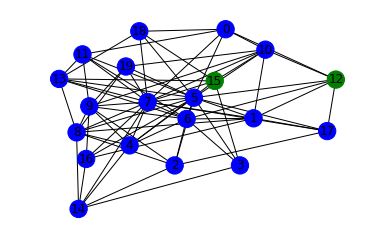

In [ ]:
draw_vset(G,Z)

We shall use an adapted version of a power set (namely, iterate on all subsets of order at most some value $k$). For this, we use itertools and encode a short function that returns an iterable object on all subsets of order at most $k$.

In [ ]:
from itertools import chain, combinations

def powerset(iterable,k):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(k+1))

Idea is the following. Given a graph $G$, a target value $k$ and a vertex cover (possibly non-optimal) $Z$, we want to decide if there is a vertex cover of order at most $k$.

We iterate over all possible intersection of such a vertex cover with $Z$. For some subset $X$ of $Z$ of order less than $k$, observe that the graph induced by $Z-X$ must be empty (no edge) otherwise there cannot be a vertex cover intersecting $Z$ exactly on $X$. Morevover, every neighbor of some vertex in $Z-X$ must be in such a vertex cover. Finally, $X \cup N(Z-X)$ is a vertex cover (because by hypothesis, $Z$ is a vertex cover so $G-Z$ is a stable graph).

In our specific case, since we know that $Z$ is provided by a 2-approx, we may straightforwardly say NO if the order of $Z$ is strictly greater than $2k$.

In [ ]:
def compress_VC(G,k,Z):
    if len(Z)>2*k: return False
    else:
        PZ = powerset(Z,k)
        for X in PZ:
            XZ = set(X)
            W = Z.difference(XZ)
            H = G.subgraph(W)
            if nx.is_empty(H):
                NW=set([])
                for u in W:
                    NW = NW.union(nx.neighbors(G,u))
                TOT = XZ.union(NW)
                if len(TOT)<=k:
                    return TOT
        return False            

Apply this on graph $G$ and vertex cover $Z$ for some adequate values of $k$.

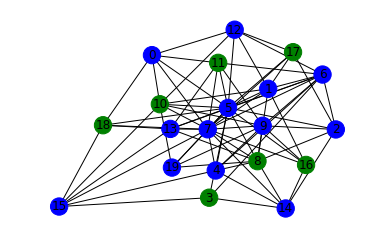

In [ ]:
Z1=compress_VC(G,13,Z)
if Z1:
    draw_vset(G,Z1)

Since $Z$ has order bounded by $2k$, we obtain an algorithm running in time $4^kn^{O(1)}$. This 4 is mostly due to our 2-approximation in the first step. What if we had a guarantee of $1 + \epsilon$? Well we can actually do even better and keep in our memory a vertex cover of order $k+1$. This is the whole point of iterative compression.

Suppose the vertices of $G$ are numbered from $0$ to $n-1$. Let $G_i$ denote the graph induced by vertices $0$ to $i$. By taking all vertices of $G_{k}$ we have an obvious vertex cover of order $k+1$. Thus we may compress it. If the answer is NO, we may as well conclude for $G$. If the answer is YES, we may add vertex $k+1$ and thus get a vertex cover of order at most $k+1$ for $G_{k+1}$... 

In [ ]:
def VC_it_comp(G,k): # Assumes that vertices of G are numbered from 0 to n.
    N = G.order()
    if N <= k:
        return set(G.nodes())
    else:
        X = VC_it_comp(G.subgraph(range(N-1)),k)
        if X==False: 
            return False
        else:
            X1=X.union(set([N-1]))
            X2=compress_VC(G,k,X1)
            return(X2)   

In [ ]:
VC_it_comp(G,13)

{5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18}

In [ ]:
G=nx.barabasi_albert_graph(40,3)

In [ ]:
VC_it_comp(G,20)

{0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 17, 18, 19, 21, 23, 25, 26, 27, 31, 32}

What is now the time complexity of your algorithm? Try to see the dependency on $n$ empirically.

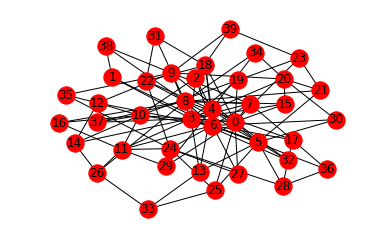

In [ ]:
nx.draw_networkx(G)
limits=plt.axis('off')  # turn off axis
plt.show()